## Import libraries

In [245]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [246]:
# Load the training data
train_df = pd.read_csv('bike_train.csv')
test_df = pd.read_csv('bike_test.csv')

print(f"Bike Training data shape: {train_df.shape}")
print(f"Bike Test data shape: {test_df.shape}")
print("\nFirst few rows of training data:")
train_df.head()

Bike Training data shape: (10450, 12)
Bike Test data shape: (2613, 9)

First few rows of training data:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [247]:
# Data information
print("Training Data Info:")
print(train_df.info())
print("\nBasic Statistics:")
train_df.describe()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  float64
 7   humidity    10450 non-null  int64  
 8   windspeed   10450 non-null  float64
 9   casual      10450 non-null  int64  
 10  registered  10450 non-null  int64  
 11  count       10450 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 979.8+ KB
None

Basic Statistics:


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000
mean,2.507943,0.028804,0.675694,1.413876,20.191700,23.605793,61.924211,12.765259,35.869091,154.511675,190.410526
std,1.116946,0.167263,0.468137,0.632258,7.792683,8.478045,19.245193,8.102821,49.629436,150.861267,181.038755
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.450050,16.000000,117.000000,143.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,221.000000,283.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [248]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Missing values in test data:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


## 2. Data pre-processing and Feature Engineering

In [249]:
def parse_datetime(df):
    """Extract datetime features from the datetime column"""
    df = df.copy()
    
    # Parse datetime - handle multiple formats
    # Train data: YYYY-MM-DD HH:MM:SS, Test data: DD-MM-YYYY HH:MM
    df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', dayfirst=True)
    
    # Extract time-based features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['dayofyear'] = df['datetime'].dt.dayofyear
    
    # Create cyclical features for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Create cyclical features for month (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Create cyclical features for day of week (7-day cycle)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df

def create_features(df):
    """Create additional features"""
    df = df.copy()
    
    # One-hot encoding for season (1=Spring, 2=Summer, 3=Fall, 4=Winter)
    df['season_spring'] = (df['season'] == 1).astype(int)
    df['season_summer'] = (df['season'] == 2).astype(int)
    df['season_fall'] = (df['season'] == 3).astype(int)
    df['season_winter'] = (df['season'] == 4).astype(int)
    
    # One-hot encoding for weather (1=Clear, 2=Mist, 3=Light Rain/Snow, 4=Heavy Rain/Snow)
    df['weather_clear'] = (df['weather'] == 1).astype(int)
    df['weather_mist'] = (df['weather'] == 2).astype(int)
    df['weather_light_rain'] = (df['weather'] == 3).astype(int)
    df['weather_heavy_rain'] = (df['weather'] == 4).astype(int)
    
    # Peak hours (morning and evening rush)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | 
                          (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    
    # Time of day categories
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[0, 6, 12, 18, 24],
                               labels=['night', 'morning', 'afternoon', 'evening'],
                               include_lowest=True)
    df['time_of_day'] = df['time_of_day'].cat.codes
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Interaction features
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_windspeed'] = df['temp'] * df['windspeed']
    df['feels_like_diff'] = df['atemp'] - df['temp']
    
    # Working day and hour interaction
    df['workingday_hour'] = df['workingday'] * df['hour']
    
    return df

# Apply feature engineering on Train data
train_df = parse_datetime(train_df)
# Delete duplicate rows where year, month, day, and hour are the same
train_df = train_df.sort_values('datetime').reset_index(drop=True)
duplicates_mask = train_df.duplicated(subset=['year', 'month', 'day', 'hour'], keep='first')
deleted_duplicates = train_df[duplicates_mask]
print("Duplicate entries deleted (same year, month, day, hour):")
print(deleted_duplicates[['datetime', 'year', 'month', 'day', 'hour']])

# Drop these duplicates from train_df
train_df = train_df[~duplicates_mask].reset_index(drop=True)
print(train_df.head())
train_df = create_features(train_df)

# Apply feature engineering on Test data
test_df = parse_datetime(test_df)
test_df = create_features(test_df)

print("Feature engineering completed!")
print(f"\nTraining data shape after feature engineering: {train_df.shape}")
print(f"Test data shape after feature engineering: {test_df.shape}")
print("\nNew features created:")
print(train_df.columns.tolist())

Duplicate entries deleted (same year, month, day, hour):
                 datetime  year  month  day  hour
11    2011-01-01 13:00:01  2011      1    1    13
14    2011-01-01 16:00:01  2011      1    1    16
17    2011-01-01 18:00:02  2011      1    1    18
24    2011-01-02 01:00:01  2011      1    2     1
31    2011-01-02 10:00:01  2011      1    2    10
...                   ...   ...    ...  ...   ...
10417 2012-12-18 12:00:01  2012     12   18    12
10429 2012-12-19 02:00:01  2012     12   19     2
10431 2012-12-19 04:00:01  2012     12   19     4
10438 2012-12-19 10:00:01  2012     12   19    10
10442 2012-12-19 14:00:01  2012     12   19    14

[1414 rows x 5 columns]
             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
3 2011-01-

## 3. Exploratory Data Analysis (EDA)

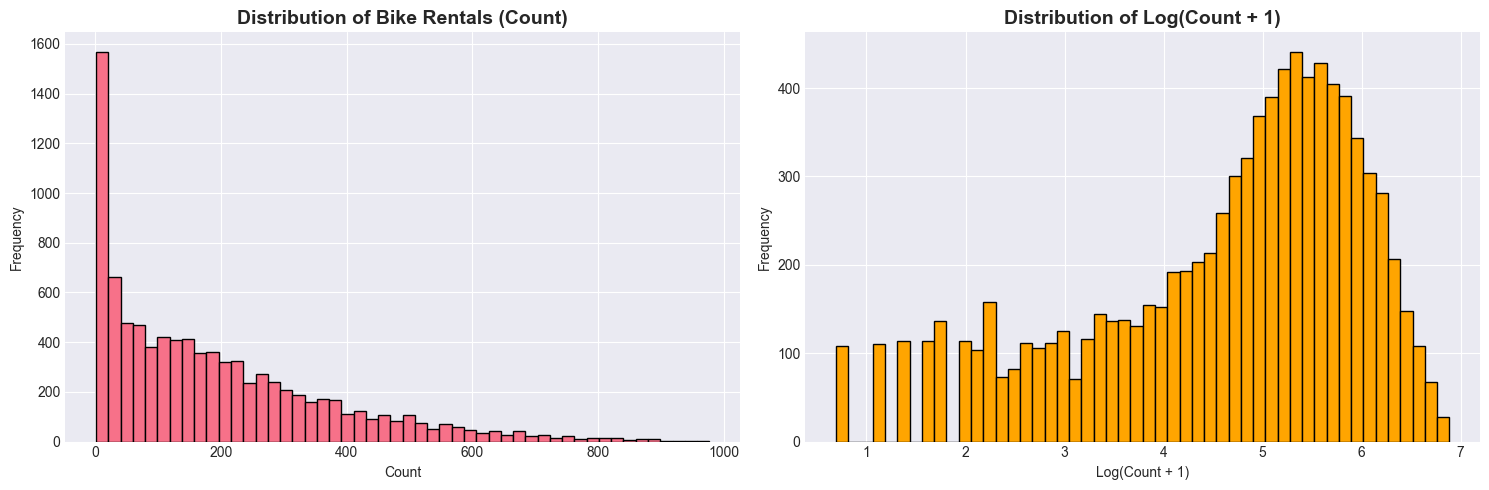

Skewness of count: 1.24
Skewness of log(count+1): -0.86


In [250]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution
axes[0].hist(train_df['count'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Bike Rentals (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')

# Log-transformed distribution
axes[1].hist(np.log1p(train_df['count']), bins=50, edgecolor='black', color='orange')
axes[1].set_title('Distribution of Log(Count + 1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Count + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Skewness of count: {train_df['count'].skew():.2f}")
print(f"Skewness of log(count+1): {np.log1p(train_df['count']).skew():.2f}")

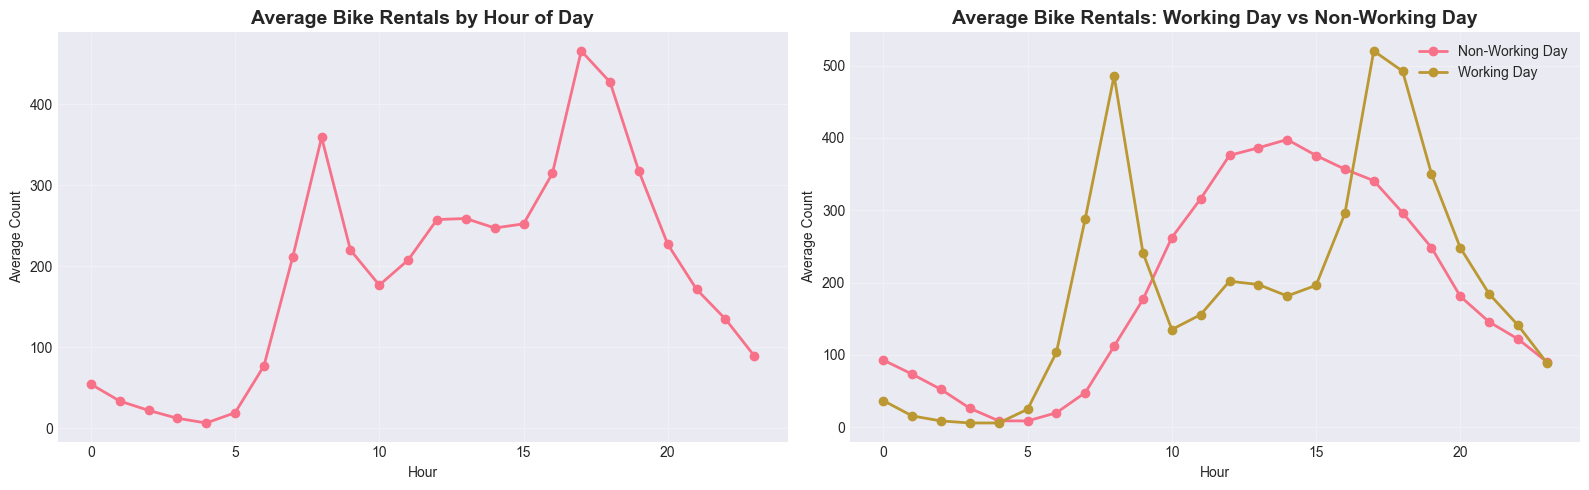

In [251]:
# Bike rentals by hour
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

hourly_data = train_df.groupby('hour')['count'].mean()
axes[0].plot(hourly_data.index, hourly_data.values, marker='o', linewidth=2)
axes[0].set_title('Average Bike Rentals by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Average Count')
axes[0].grid(True, alpha=0.3)

# By hour and working day
hourly_working = train_df.groupby(['hour', 'workingday'])['count'].mean().unstack()
hourly_working.plot(ax=axes[1], marker='o', linewidth=2)
axes[1].set_title('Average Bike Rentals: Working Day vs Non-Working Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Average Count')
axes[1].legend(['Non-Working Day', 'Working Day'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

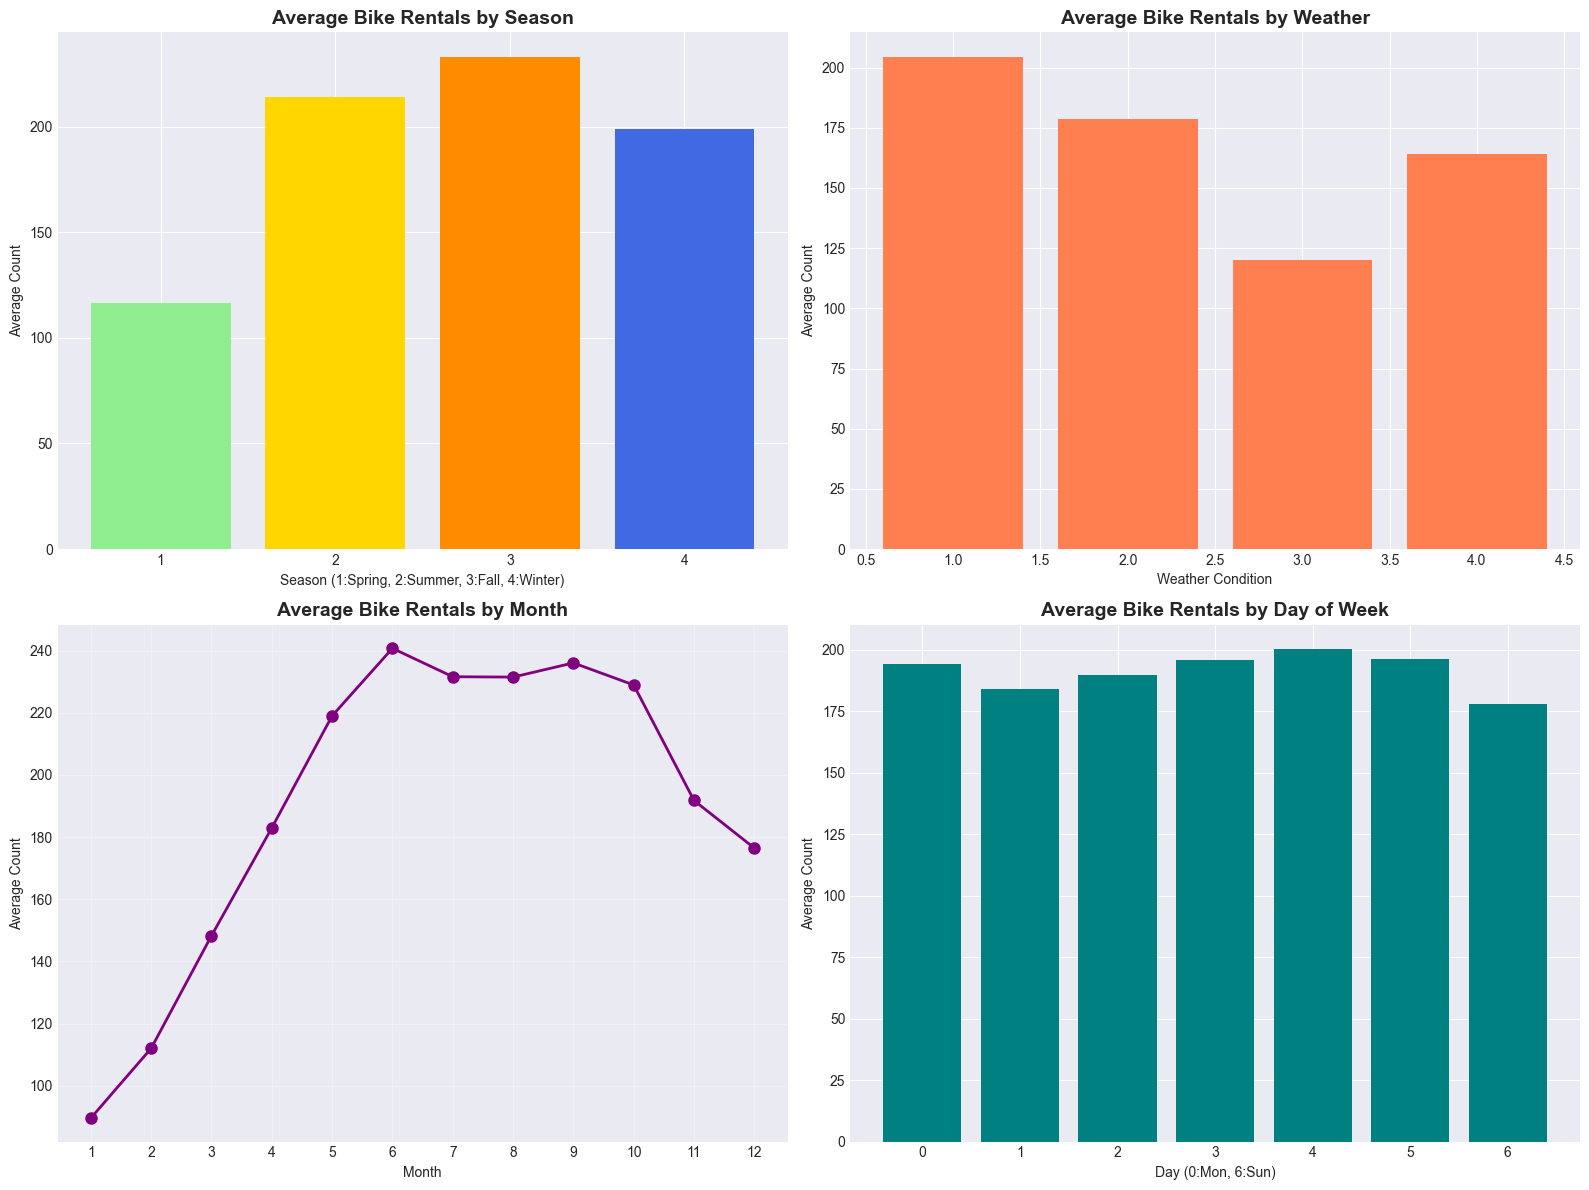

In [252]:
# Bike rentals by various categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By season
season_data = train_df.groupby('season')['count'].mean()
axes[0, 0].bar(season_data.index, season_data.values, color=['#90EE90', '#FFD700', '#FF8C00', '#4169E1'])
axes[0, 0].set_title('Average Bike Rentals by Season', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season (1:Spring, 2:Summer, 3:Fall, 4:Winter)')
axes[0, 0].set_ylabel('Average Count')
axes[0, 0].set_xticks([1, 2, 3, 4])

# By weather
weather_data = train_df.groupby('weather')['count'].mean()
axes[0, 1].bar(weather_data.index, weather_data.values, color='coral')
axes[0, 1].set_title('Average Bike Rentals by Weather', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Weather Condition')
axes[0, 1].set_ylabel('Average Count')

# By month
month_data = train_df.groupby('month')['count'].mean()
axes[1, 0].plot(month_data.index, month_data.values, marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_title('Average Bike Rentals by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Count')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# By day of week
dow_data = train_df.groupby('dayofweek')['count'].mean()
axes[1, 1].bar(dow_data.index, dow_data.values, color='teal')
axes[1, 1].set_title('Average Bike Rentals by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day (0:Mon, 6:Sun)')
axes[1, 1].set_ylabel('Average Count')
axes[1, 1].set_xticks(range(7))

plt.tight_layout()
plt.show()

Correlation with target variable (count):
count                 1.000000
is_rush_hour          0.459676
hour                  0.403188
time_of_day           0.394730
temp                  0.393669
atemp                 0.388028
temp_windspeed        0.302204
workingday_hour       0.260160
year                  0.259990
dayofyear             0.168299
month                 0.167296
quarter               0.163106
season                0.163106
season_fall           0.134731
feels_like_diff       0.134028
weather_clear         0.103104
windspeed             0.102273
season_summer         0.072920
temp_humidity         0.062705
season_winter         0.025451
day                   0.015848
workingday            0.014423
holiday              -0.001314
weather_heavy_rain   -0.001577
dayofweek_sin        -0.003569
dayofweek            -0.005858
is_weekend           -0.014322
dayofweek_cos        -0.025485
weather_mist         -0.040422
weather_light_rain   -0.115004
weather              -0.1258

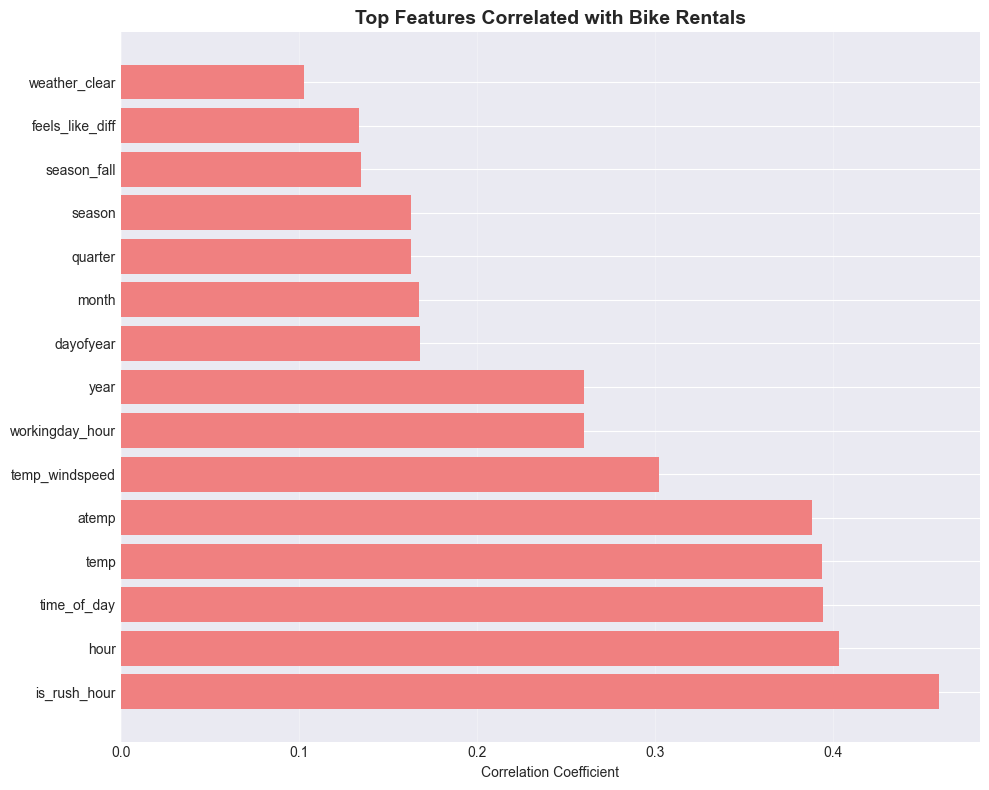

In [253]:
# Correlation with target variable
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('count')  # Remove target
numerical_cols = [col for col in numerical_cols if col not in ['casual', 'registered']]  # Remove if present

correlations = train_df[numerical_cols + ['count']].corr()['count'].sort_values(ascending=False)
print("Correlation with target variable (count):")
print(correlations)
# Save correlations to CSV
corr_df = correlations.reset_index()
corr_df.columns = ['feature', 'correlation_with_count']
corr_df.to_csv('correlations.csv', index=False)
print(f"Saved {len(corr_df)} feature correlations to 'correlations.csv'")
corr_df.head(20)


# Plot top correlations
plt.figure(figsize=(10, 8))
top_corr = correlations[1:16]
colors = ['lightcoral' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top Features Correlated with Bike Rentals', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

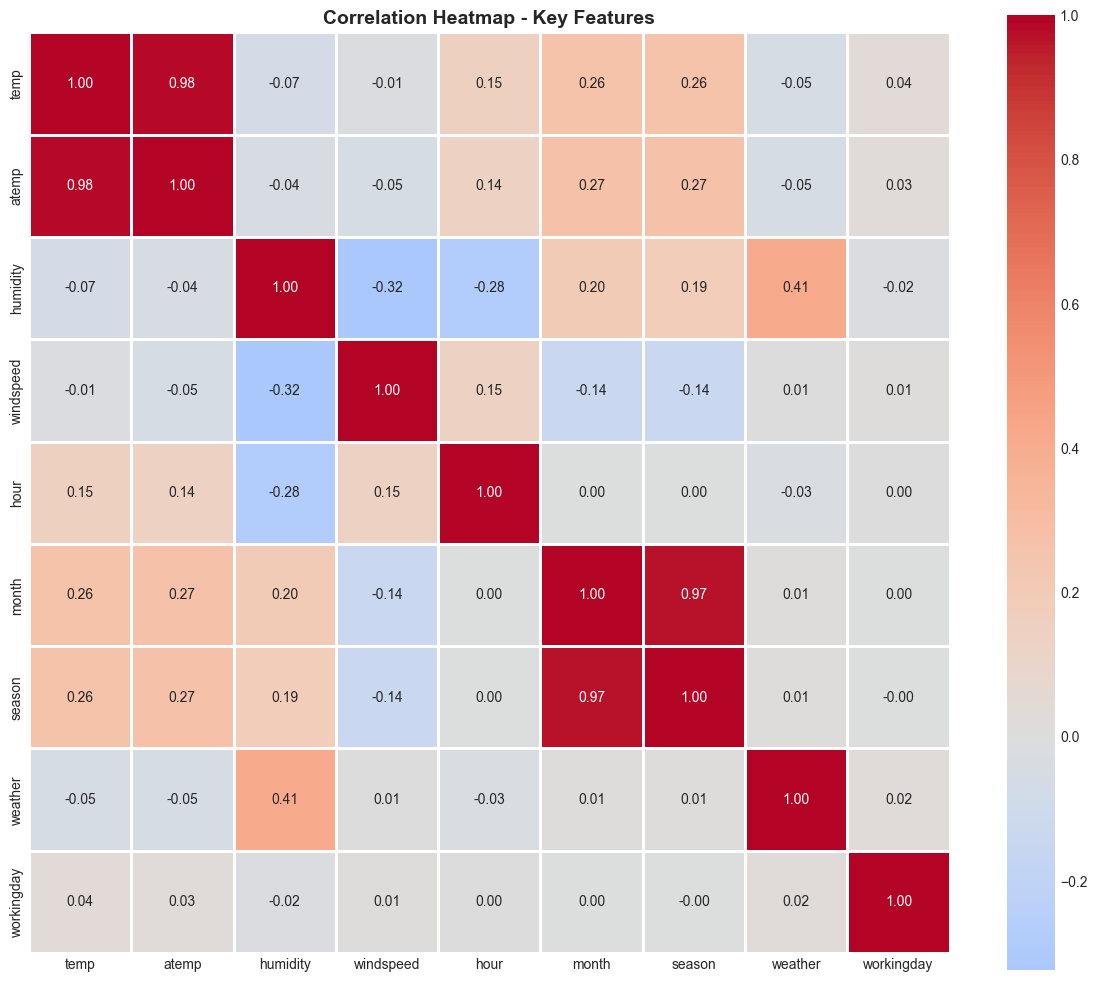

In [254]:
# Correlation heatmap for key features
key_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month', 'season', 'weather', 'workingday']
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[key_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

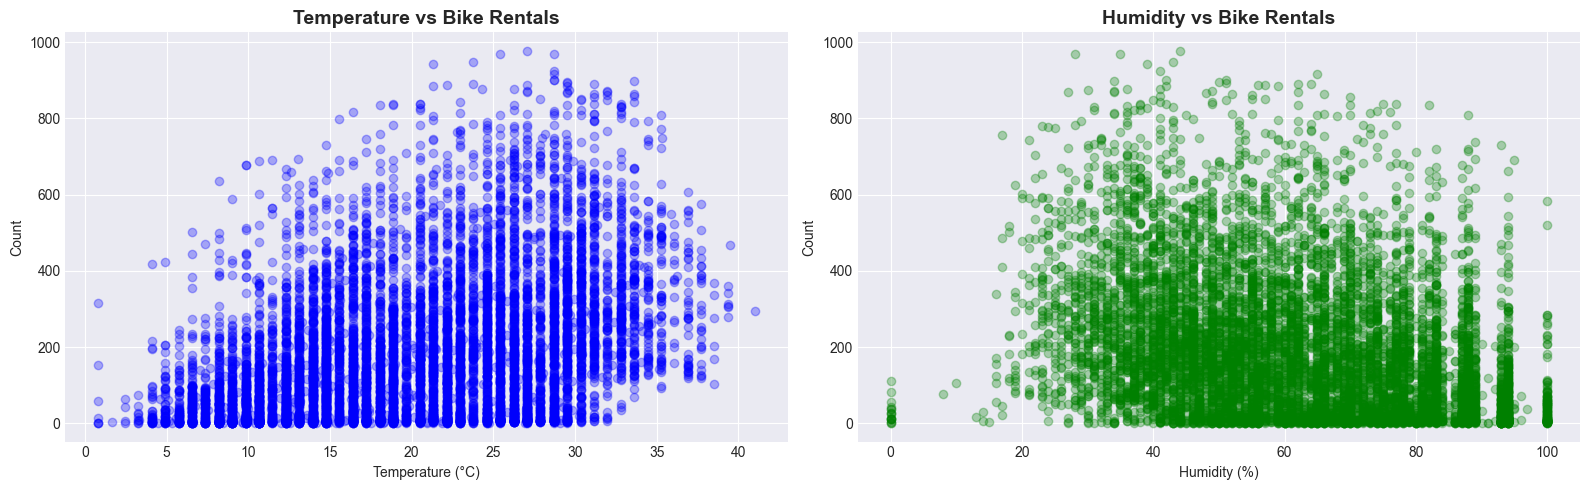

In [255]:
# Weather conditions impact
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Temperature vs Count
axes[0].scatter(train_df['temp'], train_df['count'], alpha=0.3, color='blue')
axes[0].set_title('Temperature vs Bike Rentals', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Count')

# Humidity vs Count
axes[1].scatter(train_df['humidity'], train_df['count'], alpha=0.3, color='green')
axes[1].set_title('Humidity vs Bike Rentals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Humidity (%)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Data Preparation for Modeling

In [256]:
# Separate features and target
# Dropping columns that are not needed for modeling
drop_cols = ['datetime', 'casual', 'registered', 'count']
drop_cols = [col for col in drop_cols if col in train_df.columns]

X_full = train_df.drop(columns=drop_cols)
y = train_df['count']

# Feature selection: Remove low-correlation and redundant features
features_to_drop = [
    'weather_heavy_rain',
    'dayofweek_sin', 'dayofweek_cos',  # Simpler to use is_weekend
    'dayofweek',
    'is_weekend',
    'weather_mist',
    'month_sin',
    'month_cos',
    'season',  # Replaced by one-hot encoded season features
    'weather',  # Replaced by one-hot encoded weather features
    'atemp',  # Highly correlated with temp
    # 'dayofyear',  # Redundant with month/day
    'day',  # Less important than hour, month, dayofweek
    'weather_season',
    # 'year',  # Only 2 years in data, captured by other temporal features
    # 'quarter',  # Redundant with month
    # 'feels_like_diff',  # Derived from temp and atemp which are correlated
    # 'humidity',  # Low correlation with target
    # 'windspeed',  # Low correlation with target
    # 'temp_humidity',
    # 'temp_windspeed',
    # 'month',
]

# Keep most important features based on correlation and domain knowledge
X = X_full.drop(columns=features_to_drop, errors='ignore')

# For test data
X_test_full = test_df.drop(columns=['datetime'], errors='ignore')
X_test = X_test_full.drop(columns=features_to_drop, errors='ignore')

# Ensure test data has same columns as training data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"\nFeatures removed: {features_to_drop}")
print(f"Features used for modeling ({len(X.columns)}): {X.columns.tolist()}")

Feature matrix shape: (9036, 24)
Target shape: (9036,)
Test data shape: (2613, 24)

Features removed: ['weather_heavy_rain', 'dayofweek_sin', 'dayofweek_cos', 'dayofweek', 'is_weekend', 'weather_mist', 'month_sin', 'month_cos', 'season', 'weather', 'atemp', 'day', 'weather_season']
Features used for modeling (24): ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'quarter', 'dayofyear', 'hour_sin', 'hour_cos', 'season_spring', 'season_summer', 'season_fall', 'season_winter', 'weather_clear', 'weather_light_rain', 'is_rush_hour', 'time_of_day', 'temp_humidity', 'temp_windspeed', 'feels_like_diff', 'workingday_hour']


In [257]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training set size: {X_train.shape[0]} (90%)")
print(f"Validation set size: {X_val.shape[0]} (10%)")
print(f"Test set size: {X_test.shape[0]}")

# Feature Scaling - Important for linear models with regularization
print("\nApplying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Feature scaling completed!")

Training set size: 8132 (90%)
Validation set size: 904 (10%)
Test set size: 2613

Applying feature scaling...
Feature scaling completed!


### Polynomial Feature Transformation

In [258]:
# Set polynomial degree
poly_degree = 3

print(f"Applying polynomial feature transformation (degree={poly_degree})...")
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)

# Transform training, validation, and test sets
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")
print(f"Feature names (first 20): {poly.get_feature_names_out()[:20]}")

# Now scale the polynomial features
scaler_poly = StandardScaler()
X_train_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_scaled = scaler_poly.transform(X_val_poly)
X_test_scaled = scaler_poly.transform(X_test_poly)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled)

print("Polynomial feature transformation completed!")


Applying polynomial feature transformation (degree=3)...
Original features: 24
Polynomial features: 2924
Feature names (first 20): ['holiday' 'workingday' 'temp' 'humidity' 'windspeed' 'year' 'month'
 'hour' 'quarter' 'dayofyear' 'hour_sin' 'hour_cos' 'season_spring'
 'season_summer' 'season_fall' 'season_winter' 'weather_clear'
 'weather_light_rain' 'is_rush_hour' 'time_of_day']
Original features: 24
Polynomial features: 2924
Feature names (first 20): ['holiday' 'workingday' 'temp' 'humidity' 'windspeed' 'year' 'month'
 'hour' 'quarter' 'dayofyear' 'hour_sin' 'hour_cos' 'season_spring'
 'season_summer' 'season_fall' 'season_winter' 'weather_clear'
 'weather_light_rain' 'is_rush_hour' 'time_of_day']
Polynomial feature transformation completed!
Polynomial feature transformation completed!


## 5. Model Building and Evaluation

In [259]:
def get_rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true ))** 2))
                       
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, use_log_transform=False):
    """Train and evaluate a model"""
    # Optional: train on log-transformed target for better handling of count data
    if use_log_transform:
        y_train_log = np.log1p(y_train)
        model.fit(X_train, y_train_log)
        y_train_pred = np.expm1(model.predict(X_train))  # Transform back
        y_val_pred = np.expm1(model.predict(X_val))
    else:
        # Train the model
        model.fit(X_train, y_train)
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    # Ensure predictions are non-negative
    y_train_pred = np.maximum(0, y_train_pred)
    y_val_pred = np.maximum(0, y_val_pred)
    
    # Calculate RMSLE (Root Mean Squared Logarithmic Error)
    train_rmsle = get_rmsle(y_train, y_train_pred)
    val_rmsle = get_rmsle(y_val, y_val_pred)
    
    # Calculate other metrics for additional insight
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"Training RMSLE: {train_rmsle:.4f}")
    print(f"Validation RMSLE: {val_rmsle:.4f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_rmsle': train_rmsle,
        'val_rmsle': val_rmsle,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

# Store results
results = []

In [260]:
# 1. Linear Regression
print("\n" + "="*60)
print("Training Linear Models with Optimized Features")
print("="*60)

lr = LinearRegression()
lr_results = evaluate_model(lr, X_train_scaled, y_train, X_val_scaled, y_val, 
                           "Linear Regression", use_log_transform=True)
results.append(lr_results) 


Training Linear Models with Optimized Features

Linear Regression
Training RMSLE: 0.2560
Validation RMSLE: 0.3745
Training RMSE: 36.99
Validation RMSE: 55.30
Training MAE: 22.97
Validation MAE: 32.90
Training R²: 0.9580
Validation R²: 0.9105

Linear Regression
Training RMSLE: 0.2560
Validation RMSLE: 0.3745
Training RMSE: 36.99
Validation RMSE: 55.30
Training MAE: 22.97
Validation MAE: 32.90
Training R²: 0.9580
Validation R²: 0.9105


In [261]:
# 2. Ridge Regression
ridge = Ridge(alpha=0.0001, random_state=42)
ridge_results = evaluate_model(ridge, X_train_scaled, y_train, X_val_scaled, y_val, 
                              "Ridge Regression", use_log_transform=True)
results.append(ridge_results)


Ridge Regression
Training RMSLE: 0.2644
Validation RMSLE: 0.3444
Training RMSE: 36.73
Validation RMSE: 49.44
Training MAE: 22.76
Validation MAE: 30.75
Training R²: 0.9586
Validation R²: 0.9285


In [262]:
# 3. Lasso Regression
lasso = Lasso(alpha=0.001, random_state=42, max_iter=10000)
lasso_results = evaluate_model(lasso, X_train_scaled, y_train, X_val_scaled, y_val, 
                              "Lasso Regression", use_log_transform=True)
results.append(lasso_results)


Lasso Regression
Training RMSLE: 0.3567
Validation RMSLE: 0.3736
Training RMSE: 52.17
Validation RMSE: 55.35
Training MAE: 34.28
Validation MAE: 37.92
Training R²: 0.9165
Validation R²: 0.9104


In [263]:
# Compare all models
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Train RMSLE': r['train_rmsle'],
    'Val RMSLE': r['val_rmsle'],
    'Train RMSE': r['train_rmse'],
    'Val RMSE': r['val_rmse'],
    'Train MAE': r['train_mae'],
    'Val MAE': r['val_mae'],
    'Train R²': r['train_r2'],
    'Val R²': r['val_r2']
} for r in results])

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))

# Find best model based on validation RMSLE
best_model_idx = comparison_df['Val RMSLE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest Model (lowest validation RMSLE): {best_model_name}")
print(f"Best Validation RMSLE: {comparison_df.loc[best_model_idx, 'Val RMSLE']:.4f}")


MODEL COMPARISON
            Model  Train RMSLE  Val RMSLE  Train RMSE  Val RMSE  Train MAE   Val MAE  Train R²   Val R²
Linear Regression     0.256037   0.374534   36.989778 55.295874  22.966217 32.901233  0.958020 0.910524
 Ridge Regression     0.264373   0.344425   36.727104 49.444735  22.763051 30.746689  0.958614 0.928458
 Lasso Regression     0.356686   0.373590   52.174906 55.347453  34.283647 37.918844  0.916478 0.910357

Best Model (lowest validation RMSLE): Ridge Regression
Best Validation RMSLE: 0.3444


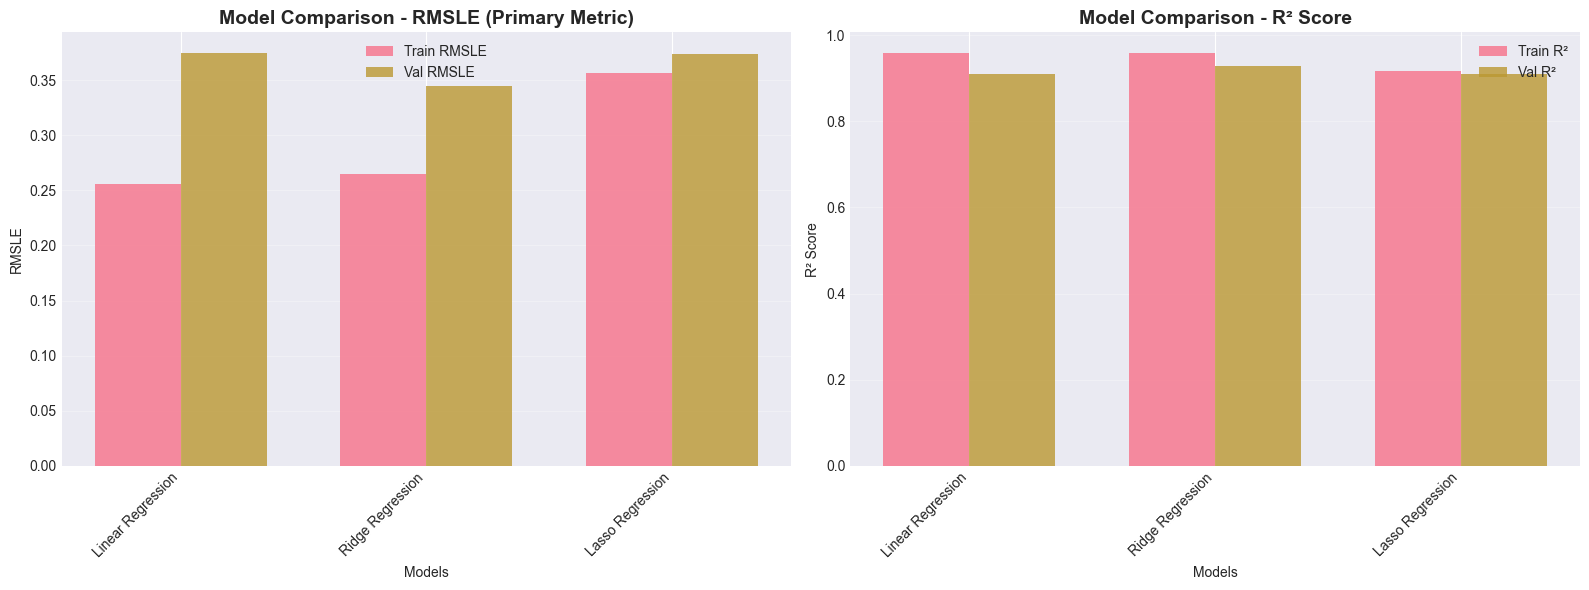

In [264]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = np.arange(len(comparison_df))
width = 0.35

# RMSLE comparison (Primary metric)
axes[0].bar(x_pos - width/2, comparison_df['Train RMSLE'], width, label='Train RMSLE', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Val RMSLE'], width, label='Val RMSLE', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('RMSLE')
axes[0].set_title('Model Comparison - RMSLE (Primary Metric)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[1].bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Val R²'], width, label='Val R²', alpha=0.8)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [265]:
# Create validation results CSV for analysis
print("Creating validation results file...")

# Get best model from results
best_model = results[best_model_idx]['model']

# Get predictions from best model (using SCALED validation data)
# Remember: model was trained on log-transformed target, so predictions are in log space
val_predictions_log = best_model.predict(X_val_scaled)
val_predictions = np.expm1(val_predictions_log)  # Inverse transform from log space
val_predictions = np.maximum(0, val_predictions)

# Get the datetime values for validation set
# Need to get original indices to match with train_df
val_indices = y_val.index
val_datetime = train_df.loc[val_indices, 'datetime'].values

# Create a simple dataframe with only 3 columns
validation_results = pd.DataFrame({
    'datetime': val_datetime,
    'actual_count': y_val.values,
    'predicted_count': val_predictions
})

# Calculate metrics for display
val_rmsle = get_rmsle(y_val, val_predictions)
absolute_error = np.abs(y_val.values - val_predictions)
percentage_error = np.abs((y_val.values - val_predictions) / (y_val.values + 1)) * 100

# Save to CSV
# validation_results.to_csv('validation_results.csv', index=False)

print(f"Validation results saved to: validation_results.csv")
print(f"\nValidation Set Performance:")
print(f"  - Samples: {len(validation_results)}")
print(f"  - RMSLE: {val_rmsle:.4f}")
print(f"  - Mean Absolute Error: {absolute_error.mean():.2f}")
print(f"  - Mean Percentage Error: {percentage_error.mean():.2f}%")
print(f"\nFirst few predictions vs actual:")
print(validation_results.head(10))

Creating validation results file...
Validation results saved to: validation_results.csv

Validation Set Performance:
  - Samples: 904
  - RMSLE: 0.3444
  - Mean Absolute Error: 30.75
  - Mean Percentage Error: 25.03%

First few predictions vs actual:
             datetime  actual_count  predicted_count
0 2012-11-18 23:00:00            59        77.003378
1 2011-04-11 12:00:00           134       140.333381
2 2012-01-13 21:00:00           102       135.734084
3 2012-09-01 09:00:00           237       274.105732
4 2012-09-08 11:00:00           578       499.689563
5 2012-05-09 10:00:00           153       198.281763
6 2012-11-10 17:00:00           501       436.877131
7 2011-11-01 20:00:00           209       197.719820
8 2012-04-13 03:00:00            11         3.723475
9 2011-12-12 05:00:00            21        13.844338


## 6. Model Predictions and Residual Analysis

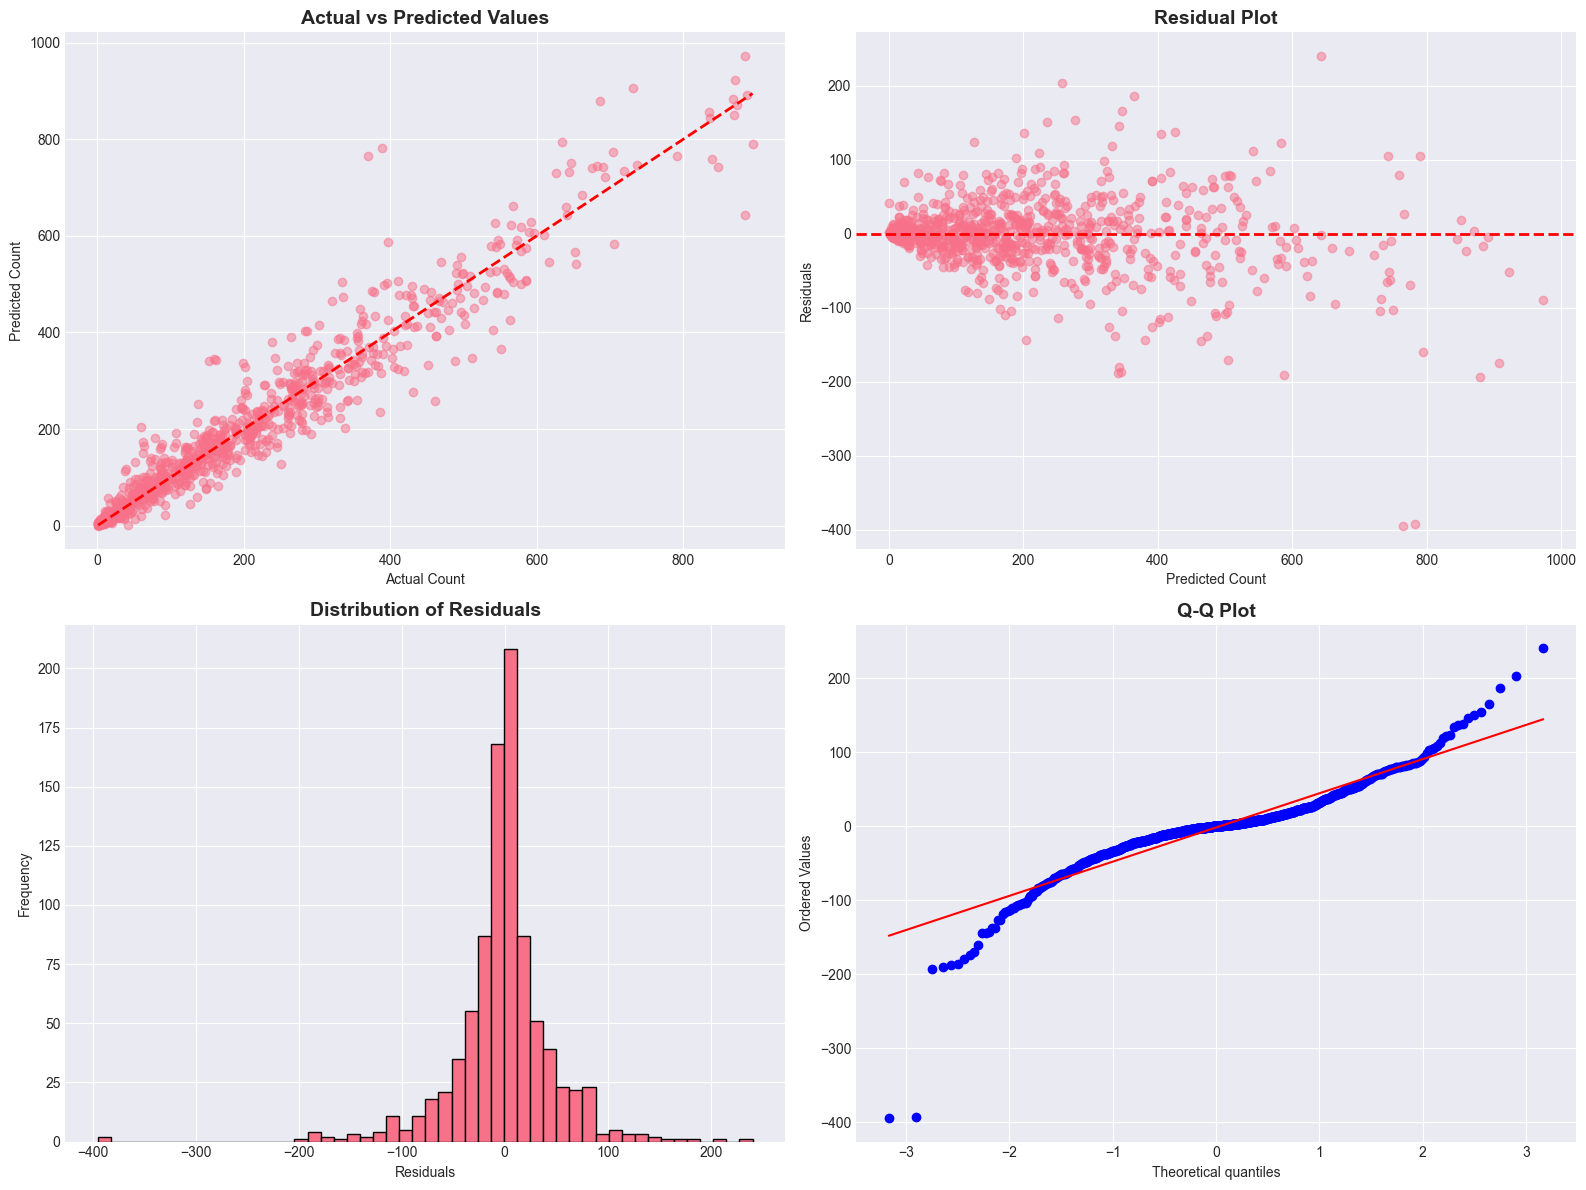


Residual Statistics:
Mean: -1.61
Std: 49.45
Min: -394.57
Max: 240.65


In [266]:
# Get best model
best_model = results[best_model_idx]['model']

# Make predictions (using SCALED validation data and inverse transform)
y_val_pred_log = best_model.predict(X_val_scaled)
y_val_pred = np.expm1(y_val_pred_log)  # Inverse transform from log space
y_val_pred = np.maximum(0, y_val_pred)

# Residual analysis
residuals = y_val - y_val_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted
axes[0, 0].scatter(y_val, y_val_pred, alpha=0.5)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Count')
axes[0, 0].set_ylabel('Predicted Count')
axes[0, 0].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')

# Residual plot
axes[0, 1].scatter(y_val_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Count')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')

# Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.2f}")
print(f"Std: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

## 7. Generate Predictions for bike_test.csv Set

In [267]:
# Train best model on full training data
print(f"Training {best_model_name} on full training data...")

# Apply polynomial transformation to full training data
print(f"Applying polynomial transformation (degree={poly_degree})...")
X_full_poly = poly.transform(X)
print(f"Full training data: {X.shape[1]} features -> {X_full_poly.shape[1]} polynomial features")

# Scale full training data with a NEW scaler
full_scaler = StandardScaler()
X_full_scaled = full_scaler.fit_transform(X_full_poly)
X_full_scaled = pd.DataFrame(X_full_scaled)

# Apply polynomial transformation to test data
X_test_poly_final = poly.transform(X_test)
print(f"Test data: {X_test.shape[1]} features -> {X_test_poly_final.shape[1]} polynomial features")

# Scale test data with the SAME scaler used for full training data
X_test_scaled_final = full_scaler.transform(X_test_poly_final)
X_test_scaled_final = pd.DataFrame(X_test_scaled_final)

# Get the best model type and retrain on full data with log transform
final_model = type(results[best_model_idx]['model'])(**results[best_model_idx]['model'].get_params())
y_log = np.log1p(y)
final_model.fit(X_full_scaled, y_log)

# Make predictions on test set (remember to inverse log transform)
test_predictions_log = final_model.predict(X_test_scaled_final)
test_predictions = np.expm1(test_predictions_log)  # Inverse of log1p
test_predictions = np.maximum(0, test_predictions)  # Ensure non-negative

print(f"\nTest set predictions generated!")
print(f"Number of predictions: {len(test_predictions)}")
print(f"Prediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")

Training Ridge Regression on full training data...
Applying polynomial transformation (degree=3)...
Full training data: 24 features -> 2924 polynomial features
Full training data: 24 features -> 2924 polynomial features
Test data: 24 features -> 2924 polynomial features
Test data: 24 features -> 2924 polynomial features

Test set predictions generated!
Number of predictions: 2613
Prediction statistics:
  Mean: 194.06
  Std: 183.47
  Min: 0.22
  Max: 1768.04

Test set predictions generated!
Number of predictions: 2613
Prediction statistics:
  Mean: 194.06
  Std: 183.47
  Min: 0.22
  Max: 1768.04


## 8. Create output file

In [268]:
# Create submission file
# Read original test file to preserve datetime format
test_original = pd.read_csv('bike_test.csv')
submission = pd.DataFrame({
    'datetime': test_original['datetime'],
    'count_predicted': np.round(test_predictions).astype(int)
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print("\nFirst few rows of submission:")
print(submission.head(10))

Submission file created: submission.csv

First few rows of submission:
           datetime  count_predicted
0   05-06-2012 5:00               16
1  19-03-2011 19:00              121
2   02-04-2012 6:00              114
3  13-07-2012 20:00              470
4  09-11-2011 19:00              300
5   10-03-2012 0:00               71
6  19-05-2011 13:00              129
7   01-05-2011 8:00               74
8   07-07-2012 8:00              143
9  07-05-2011 16:00              416


## Questionnaires
__Exploratory Data Analysis (EDA)__

Q1. Examine dataset size, missing values, and feature types. 

    The given data set has bike_train.csv with (10450 rows and 12 (features/columns))
    and bike_test.csv is with (2613 rows and 9 (features/columns)).
    In both the dataset there was no missing values observed.
    Though there were few duplicate datetime entries with different count values.
    which werer separated by 1 second.


Q2. Visualize relationships between key features and the target variable (count). 

    After analyzing the graph and observing the relationship between features, it is found that. 
    1. Hour of day is the most important feature
    2. Clear differences between working days and weekends
    3. Peak demand observed during rush hours (7-9 AM and 5-7 PM) on working days

Q3. Suggest which variables are likely to be most informative.

    From the above point, hour of the day, weekday/weekend and temperature has more corelation with count outcome.

__Feature Engineering__

Q4. You can try to derive features from datetime (hour, weekday, month, season), encode categorical variables, consider transformations to capture nonlinear trends to improve your model performance. If you do any of these, report it as answer to Q4. It is optional.

    1. datetime column is parsed to extract additional features like year, month, day, hour, dayofweek, quarter abd dayofyear. And there are some cyclical features for hour, dayofweek and month.
    2. One-hot encoding has been performed on the categorical data season and weather.

**Regression Model**

Q5. Split data into training and validation sets and build a simple Linear Regression model.

    training data is split into (90-10 split) with validation performed on the 10% of training data from bike_train.csv
    Simple linear regression model is built and evaluated in section 5.

Q6. To improve model performance, you may try to:

    a. Extend feature space using polynomial transformations (degree 2 or 3)
    I have used degree 3 polinomial transformation. but with all the features enabled, I could observe that the model was overfitting too much with validation RMSLE going more than the training RMSLE achieved. Hence, i had to manually eliminate or drop a few features which were of no relevance or contribution to the count value.

    b. Apply Ridge and Lasso regression on polynomial features, Tune the regularization strength (α).
    I have applied multiple alpha values ranging from 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0 and 10.0. Also the number of epoch iterations were tuned. And I have kept the best performing hyperparameter values.

__Model Comparison and Interpretation__

Q7. Summarize all results (of different models tried out) in one table (RMSLE, key observations).

| Model | Train RMSLE | Val RMSLE | Train RMSE | Val RMSE | Train R² | Val R² |
|-------|-------------|-----------|------------|----------|----------|--------|
| Linear Regression | 0.256037 | 0.374534 | 36.989778 | 55.295874 | 22.966217 | 32.901233 |
| Ridge Regression  | 0.261077 | 0.343593 | 36.664014 | 49.487847 | 22.676417 | 30.794680 |
| Lasso Regression  | 0.310089 | 0.344189 | 42.600107 | 50.233452 | 27.176751 | 31.689678 |

    Best Model (lowest validation RMSLE): Ridge Regression (Log Transform)
    Best Validation RMSLE: 0.3436

Q8. Plot residuals for the best model.

    The plots are available in section 6.

Q9. Explain why the winning model performs better.

    For my calculations, all models were close but Ridge model got a minor edge because it finds the sweet spot. preventing overfitting while leveraging the rich polynomial feature space to capture complex non-linear relationships between bike rentals and time/weather variables.

__Reflection Questions__

Q10. Why does RMSLE penalize under-predictions more gently than RMSE?

    RMSLE uses logarithmic scale where the relative error matters more than absolute error, so under-predicting 50 vs 100 (50% error) has similar penalty as under-predicting 500 vs 1000 (50% error), while RMSE would penalize the latter much more heavily due to the larger absolute difference (500 vs 50).

Q11. What are the trade-offs between model simplicity and predictive power?

    Simple models (like Linear Regression) are interpretable, fast to train, and less prone to overfitting, but they can't capture complex patterns, while complex models (like degree-3 polynomials with Ridge/Lasso) achieve better predictive accuracy by modeling non-linear relationships at the cost of being harder to interpret and requiring more careful regularization to avoid overfitting.

Q12. Why can’t Linear Regression alone capture time-of-day effects effectively?

    Linear Regression assumes a simple linear relationship, but in this dataset, bike demand has a non-linear cyclic pattern with multiple peaks (morning and evening rush hours), requiring polynomial or interaction terms to model the complex U-shaped hourly pattern where hour 8 and hour 18 both have high demand despite being far apart numerically, requiring polynomial terms or interaction features to capture these complex patterns.